# Convert Translation LNM to Rotation LNM Model

In [1]:
from obspy import * 
from pandas import *
from os import listdir

import os
import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['workdir'] = data_path+"LNM/"

config['datadir_models'] = config['workdir']+"data/MODELS/"

config['datadir_data'] = config['workdir']+"data/"

config['datadir_final'] = config['workdir']+"data/FINAL/"

config['outdir_figures'] = config['workdir']+"figures_final/"

config['period_lower'] = 2.5
config['period_upper'] = 300

## Load Data

### Read Noise Models

load GSN models

In [4]:
df_gsn = read_csv(config['datadir_models']+"GSN_noise_model.csv", 
              dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'})

df_gsn.sort_values("period", inplace=True)

df_gsn['minH_acc'] = [10**(xx/20) for xx in df_gsn['minH']]
df_gsn['minZ_acc'] = [10**(xx/20) for xx in df_gsn['minZ']]

load NLNM from Petersen

In [5]:
tmp = np.load(config['datadir_models']+"noise_models.npz")

df_lnm = DataFrame()
df_lnm['periods'], df_lnm['nlnm'], df_lnm['nhnm'] = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

df_lnm['nlnm_acc'] = [10**(xx/20) for xx in df_lnm['nlnm']]
df_lnm['nhnm_acc'] = [10**(xx/20) for xx in df_lnm['nhnm']]

### Load BFO Data

Kurrle & Widmer (2004)

In [6]:
df_bfo_vhz = read_csv(config['datadir_data']+"BFO_VHZ.csv", delimiter=" ",
                      dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'}, names=["f_mhz","db"])

df_bfo_vhz['periods'] = 1 / ( df_bfo_vhz.f_mhz * 1e-3 )
df_bfo_vhz['bhz'] = 10**(df_bfo_vhz.db/10)


df_bfo_vhe = read_csv(config['datadir_data']+"BFO_VHE.csv", delimiter=" ", 
                      dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'}, names=["f_mhz","db"])

df_bfo_vhe['periods'] = 1 / ( df_bfo_vhe.f_mhz * 1e-3 )
df_bfo_vhe['bhe'] = 10**(df_bfo_vhe.db/10)

### Read Velocity Models

In [7]:
rayleigh_model = "Rayleigh_Average/RAYLEIGH_vphase_land_only.pkl"
love_model = "Love_Average/LOVE_vphase_land_only.pkl"

vphase_rayl_median = read_pickle(config['workdir']+"data/PHASE_VELOCITY_MODEL/"+rayleigh_model)
vphase_love_median = read_pickle(config['workdir']+"data/PHASE_VELOCITY_MODEL/"+love_model)

### Load Velocity Confidence Interval

In [8]:
def __get_percentiles(arr):
    
    from numpy import zeros, nanpercentile, shape
    
    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [5, 95])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]
        
    return percentiles_lower, percentiles_upper

In [9]:
df_vphase_rayl = read_pickle(config['datadir_final']+"vphase_land_rayleigh.pkl")

arr = df_vphase_rayl.iloc[:,1:].to_numpy().T

rayl_perc_lower, rayl_perc_upper = __get_percentiles(arr)

df_vphase_love = read_pickle(config['datadir_final']+"vphase_land_love.pkl")
arr = df_vphase_love.iloc[:,1:].to_numpy().T
love_perc_lower, love_perc_upper = __get_percentiles(arr)

## Interpolations

In [10]:
data = DataFrame()

data['periods'] = df_lnm['periods']

data['nlnm_acc'] = df_lnm['nlnm_acc']
data['nhnm_acc'] = df_lnm['nhnm_acc']

In [11]:
## phase velocities
data['vphase_rayl_median_interp'] = np.interp(data['periods'], vphase_rayl_median['periods_mod'], vphase_rayl_median['vphase_median'])
data['vphase_love_median_interp'] = np.interp(data['periods'], vphase_love_median['periods_mod'], vphase_love_median['vphase_median'])

## confidence interval Rayleigh
data['vphase_rayl_conf_upper'] = np.interp(data['periods'], df_vphase_rayl['period'], rayl_perc_upper)
data['vphase_rayl_conf_lower'] = np.interp(data['periods'], df_vphase_rayl['period'], rayl_perc_lower)

## confidence interval Love
data['vphase_love_conf_upper'] = np.interp(data['periods'], df_vphase_love['period'], love_perc_upper)
data['vphase_love_conf_lower'] = np.interp(data['periods'], df_vphase_love['period'], love_perc_lower)


data['gsn_minH_acc'] = np.interp(data['periods'], df_gsn['period'], df_gsn['minH_acc'])
data['gsn_minZ_acc'] = np.interp(data['periods'], df_gsn['period'], df_gsn['minZ_acc'])

## Rotation Models

In [12]:
data['rot_trans_lnm'] = data['nlnm_acc'] / (data['vphase_rayl_median_interp']*1000)
data['rot_trans_hnm'] = data['nhnm_acc'] / (data['vphase_rayl_median_interp']*1000)


data['rot_trans_gsn'] = data['gsn_minZ_acc'] / (data['vphase_rayl_median_interp']*1000)
data['rot_trans_gsn_conf_lower'] = data['gsn_minZ_acc'] / (data['vphase_rayl_conf_upper']*1000)
data['rot_trans_gsn_conf_upper'] = data['gsn_minZ_acc'] / (data['vphase_rayl_conf_lower']*1000)

data['rot_vert_gsn'] = -0.5* data['gsn_minH_acc'] / (data['vphase_love_median_interp']*1000)
data['rot_vert_gsn_conf_lower'] =  -0.5* data['gsn_minH_acc'] / (data['vphase_love_conf_upper']*1000)
data['rot_vert_gsn_conf_upper'] =  -0.5* data['gsn_minH_acc'] / (data['vphase_love_conf_lower']*1000)

Assuming only tilt for horizontal low noise of GSN above T>500 seconds: 
    
$$ rotation \ rate \ [rad/s] = acc_H (\omega) \ [rad] * \omega \ [1/s]  =  2 \pi/T \ [1/s] * acc_H (T) \ [rad] $$

In [13]:
g = 9.81

omega = (2*np.pi)/(data['periods'])

# data['rot_tilt'] = omega * data['gsn_minH_acc'] / g *np.pi/180 ## rad/s
data['rot_tilt'] = omega * data['gsn_minH_acc'] / g ## rad/s

### add eigenmodes limits

In [14]:
# data['toroidal_hum'] = np.ones(data['periods'].size) * 10**(-185/10) / (2*data['vphase_love_median_interp']*1000)**2

# data.loc[data['periods'] < 1/0.007, 'toroidal_hum'] = np.nan
# data.loc[data['periods'] > 1/0.003, 'toroidal_hum'] = np.nan

compute rotation rate for toroidal and spheroidal hum

In [22]:
df_bfo_vhe

,f_mhz,db,periods,bhe,vphase_love,toroidal_hum
0,2.043,-169.181,489.476260,1.207536e-17,3.0065,1.334109e-12
1,2.082,-169.535,480.307397,1.113012e-17,3.0065,1.280830e-12
2,2.073,-169.178,482.392668,1.208370e-17,3.0065,1.334570e-12
3,2.120,-169.757,471.698113,1.057548e-17,3.0065,1.248508e-12
4,2.130,-170.031,469.483568,9.928874e-18,3.0065,1.209738e-12
...,...,...,...,...,...,...
192,6.873,-178.723,145.496872,1.341838e-18,3.0065,4.447249e-13
193,6.901,-178.621,144.906535,1.373726e-18,3.0065,4.499782e-13
194,6.917,-179.304,144.571346,1.173816e-18,3.0065,4.159503e-13
195,6.956,-179.300,143.760782,1.174898e-18,3.0065,4.161419e-13


In [33]:
df_bfo_vhe['vphase_love'] = np.interp(df_bfo_vhe.periods, data['periods'], data['vphase_love_median_interp'])
df_bfo_vhz['vphase_rayl'] = np.interp(df_bfo_vhz.periods, data['periods'], data['vphase_rayl_median_interp'])

#df_bfo_vhe['toroidal_hum'] = (np.sqrt(df_bfo_vhe.bhe) /2 /(df_bfo_vhe['vphase_love']*1000) )**2

df_bfo_vhe['toroidal_hum'] = np.sqrt(df_bfo_vhe.bhe) * (2*np.pi /df_bfo_vhz.periods /g)
df_bfo_vhz['spheriodal_hum'] = np.sqrt(df_bfo_vhz.bhz) / (df_bfo_vhz['vphase_rayl']*1000)

In [34]:
data.loc[data['periods'] < df_bfo_vhe.periods.min(), 'bfo_vhe'] = np.nan
data.loc[data['periods'] > df_bfo_vhe.periods.max(), 'bfo_vhe'] = np.nan

In [35]:
# data['storm_g_ring'] = np.ones(data['periods'].size) * 1e-13 

# data.loc[data['periods'] < 1/0.09, 'storm_g_ring'] = np.nan
# data.loc[data['periods'] > 1/0.2, 'storm_g_ring'] = np.nan

modify dataframe

In [36]:
data.sort_values("periods", inplace=True)
data.reset_index(drop=True, inplace=True)

## Plotting

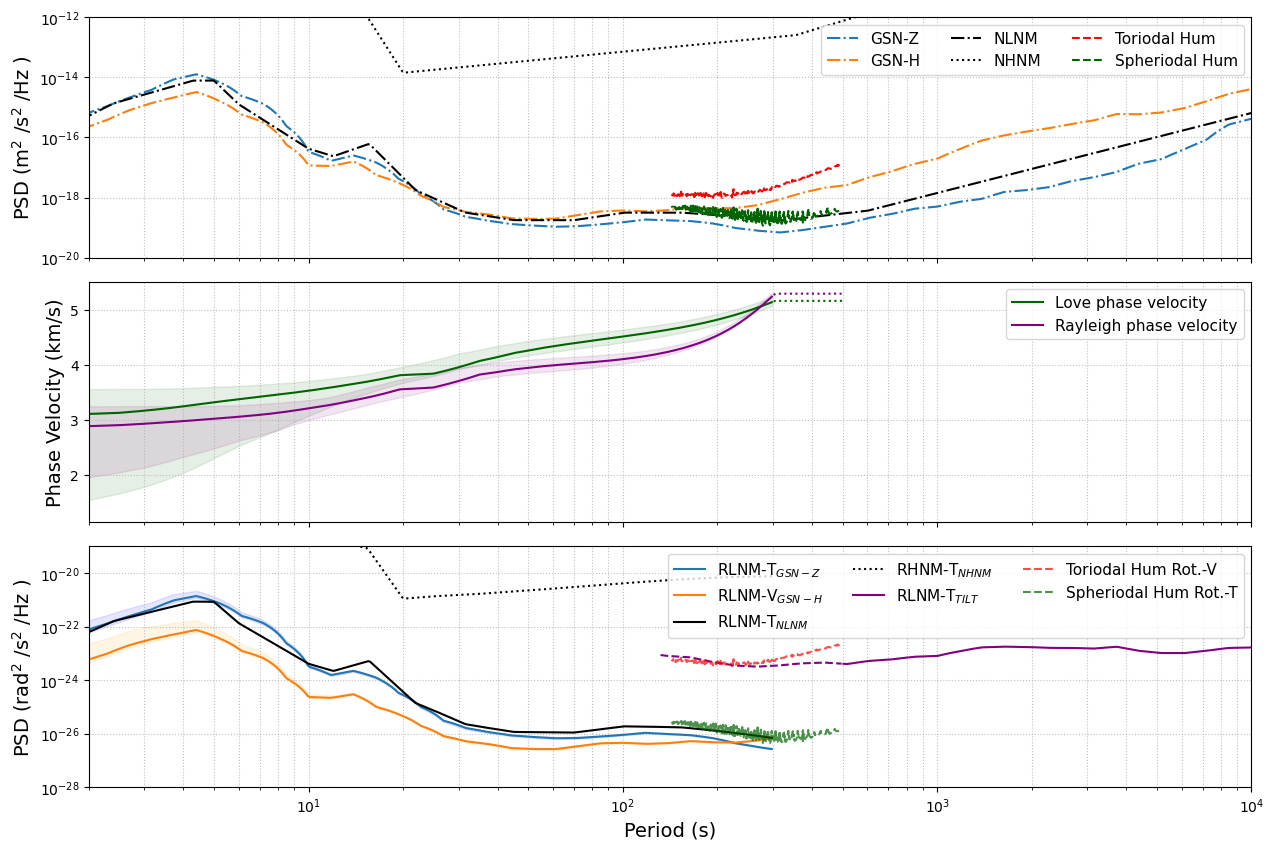

In [37]:
def __plot():
    
    N = 3
    font = 14
    
    plim = 580
    
    
    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)

    plt.subplots_adjust(hspace=0.1)
    
    ## __________________________
    
    ax[0].loglog(data['periods'], data['gsn_minZ_acc']**2, ls="-.", label="GSN-Z")
    ax[0].loglog(data['periods'], data['gsn_minH_acc']**2, ls="-.", label="GSN-H")
    ax[0].loglog(data['periods'], data['nlnm_acc']**2, label="NLNM", ls="-.", color="black")
    ax[0].loglog(data['periods'], data['nhnm_acc']**2, label="NHNM", ls=":", color="black")
    
    ## add estimate for toridal hum to rotations
    ax[0].loglog(df_bfo_vhe['periods'], df_bfo_vhe['bhe'], 'red', ls="--", label="Toriodal Hum", zorder=2)
    ax[0].loglog(df_bfo_vhz['periods'], df_bfo_vhz['bhz'], 'darkgreen', ls="--", label="Spheriodal Hum", zorder=2)
    
    
    ax[0].set_ylabel("PSD (m$^2$ /s$^2$ /Hz )", fontsize=font)
 
    ax[0].set_ylim(1e-20, 1e-12)
    
    ## __________________________
    
    ax[1].semilogx(data['periods'][:plim], data['vphase_love_median_interp'][:plim], label="Love phase velocity", color="darkgreen")
    ax[1].fill_between(data['periods'][:plim], data['vphase_love_conf_lower'][:plim], data['vphase_love_conf_upper'][:plim], color="darkgreen", alpha=0.1, zorder=0)

    ax[1].semilogx(data['periods'][:plim], data['vphase_rayl_median_interp'][:plim], label="Rayleigh phase velocity", color="purple")
    ax[1].fill_between(data['periods'][:plim], data['vphase_rayl_conf_lower'][:plim], data['vphase_rayl_conf_upper'][:plim], color="purple", alpha=0.1, zorder=0)

    ## extension of velocities towards long periods
    ax[1].semilogx(data['periods'][plim:plim+38], data['vphase_rayl_median_interp'][plim:plim+38], color="purple", ls=":")
    ax[1].semilogx(data['periods'][plim:plim+38], data['vphase_love_median_interp'][plim:plim+38], color="darkgreen", ls=":")
    
    
    ax[1].set_ylabel("Phase Velocity (km/s)", fontsize=font)
    
    ## __________________________
    
    ax[2].loglog(data['periods'][:plim], data['rot_trans_gsn'][:plim]**2, label=r"RLNM-T$_{GSN-Z}$")
    ax[2].loglog(data['periods'][:plim], data['rot_vert_gsn'][:plim]**2, label=r"RLNM-V$_{GSN-H}$")
    
    ax[2].loglog(data['periods'][:plim], data['rot_trans_lnm'][:plim]**2, color="black", label="RLNM-T$_{NLNM}$")
    ax[2].loglog(data['periods'][:plim], data['rot_trans_hnm'][:plim]**2, color="black", label="RHNM-T$_{NHNM}$", ls=":")
    
    ax[2].fill_between(data['periods'][:plim], data['rot_vert_gsn_conf_lower'][:plim]**2, data['rot_vert_gsn_conf_upper'][:plim]**2, color="orange", alpha=0.1)
    ax[2].fill_between(data['periods'][:plim], data['rot_trans_gsn_conf_lower'][:plim]**2, data['rot_trans_gsn_conf_upper'][:plim]**2, color="blue", alpha=0.1)
    
    ## add estimate for tilt to rotations
    ax[2].loglog(data['periods'][520:617], data['rot_tilt'][520:617]**2, ls="--", color="purple")
    ax[2].loglog(data['periods'][617:], data['rot_tilt'][617:]**2, label="RLNM-T$_{TILT}$", ls="-", color="purple")
    
    ## add estimate for toridal hum to rotations
    ax[2].loglog(df_bfo_vhe['periods'], df_bfo_vhe['toroidal_hum']**2, 'red', ls="--", label="Toriodal Hum Rot.-V", zorder=2, alpha=0.7)
    ax[2].loglog(df_bfo_vhz['periods'], df_bfo_vhz['spheriodal_hum']**2, 'darkgreen', ls="--", label="Spheriodal Hum Rot.-T", zorder=2, alpha=0.7)
    
    ## test
#     ax[2].loglog(data['periods'][:plim], data['rot_trans_lnm'][:plim]**2*data['periods'][:plim], color="pink", label="RLNM-T$_{NLNM}$")
    
    
    ax[2].set_ylim(1e-28, 1e-19)

    ax[2].set_ylabel("PSD (rad$^2$ /s$^2$ /Hz )", fontsize=font)
    ax[2].set_xlabel("Period (s)", fontsize=font)
    
    for i in range(N):
        ax[i].grid(ls=":", zorder=-1, alpha=0.8, which="both")
        ax[i].tick_params(axis='x', labelsize=10)
        ax[i].tick_params(axis='y', labelsize=10)

    ax[N-1].legend(fontsize=font-3, loc=1, ncol=3)

    ax[0].legend(fontsize=font-3, loc=1, ncol=3)
    ax[1].legend(fontsize=font-3, loc=1)        
    ax[N-1].set_xlim(2, 1e4)
    
    plt.show();
    return fig
    
fig = __plot()

In [38]:
from andbro__savefig import __savefig

__savefig(fig,  config['outdir_figures'], "TLNM_to_RLNM_withTilt", mode="png", dpi=300)


   -> saving /home/andbro/kilauea-data/LNM/figures_final/TLNM_to_RLNM_withTilt.png ...

   -> Done



## Write Data to File

In [ ]:
fname = "TLNM_to_RLNM.csv"

data.to_csv(config['datadir_final']+fname, sep=",")
print(f" -> writing to {config['datadir_final']}{fname}")